$$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}$$

# Introduction to Classification

Regression and classification are two general methods for modeling supervised learning.  The primary difference between these two approachs is the type of output each model produces.  In regression, the output is one or more continuous values (sometimes referred to as *targets*).  In classification, the outputs are one of n catagorical variables which are typically referred to as *class labels*.  For example, if we wanted to predict whether a bank customer will default on a credit card payment, we might want to create a model that outputs a label such as "default" or "no default".

## Logistic Regression

**Binary classification** is the simpliest form of classification.  In this type of problem, our job is to separate the data into one of two mutually exclusive classes.  Building on the credit card default example, if we wanted to model whether a credit card holder will default on their monthly payment or not, our two output classes might be Y = 0 if no default and Y = 1 if default occurred.

Let's take a look at a credit card default data set from the UCI site.  The original data was pulled from:  

[https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).  

For convenience and performance, the data was downloaded locally.  To read the data from the UCI site directly, comment out the active **xls_url** assignment below and uncomment the line above it.  If for some reason the UCI site is unavailable, this same data file is available in the **data** folder of the **MLTools** github repo which this workbook is a part of.

In [2]:
# Start with the standard incantations...
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read xls file
import pandas as pd
# Download the data directly from the UCI repo
# http://stackoverflow.com/questions/17063458/reading-an-excel-file-in-python-using-pandas
#xls_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
xls_url = "D:\dev\MLToolbox\data\default of credit card clients.xls" # use if offline
cc_data = pd.read_excel(xls_url, sheetname='Data', header=[0, 1])
#cc_data.columns.values  # list of 2-tuples: good clue as to how to index into multiple headers...

# Download the csv version of data from either github repo or dropbox
#data_url = "https://raw.githubusercontent.com/MichaelSzczepaniak/MLToolbox/master/data/default%20of%20credit%20card%20clients.csv"
#data_url = "https://www.dropbox.com/s/9p9szqwsvi9q9gl/default%20of%20credit%20card%20clients.csv?dl=1"
#cc_data = pd.read_csv(data_url, dtype={'X12' : np.float32, 'Y' : np.float32}, header=[0, 1])

In [4]:
cc_data.loc[0:5, :]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
#cc_data.loc[0:5, ['LIMIT_BAL', 'SEX', 'BILL_AMT1']]
#cc_data.loc[0:5, ['X1', 'X2', 'X12']]
# above 2 lines result in the following error:
# KeyError: 'MultiIndex Slicing requires the index to be fully lexsorted tuple len (1), lexsort depth (0)'

data = cc_data.loc[:, [('X12', 'BILL_AMT1'), ('Y', 'default payment next month')]]
data.loc[0:5, :]

,X12,Y
ID,BILL_AMT1,default payment next month
1,3913,1
2,2682,1
3,29239,0
4,46990,0
5,8617,0


From the [documentation](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients), we see that X12 is the latest billing amount (September 2005) and that Y indicates whether there was a default (Y = 1) or not (y = 0).  Let's start with a quick plot of these two variables.

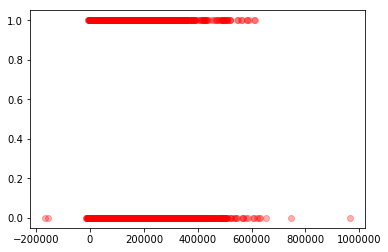

In [6]:
x = data.iloc[:, 0]
y = data.iloc[:, 1]
x = x.as_matrix()
y = y.as_matrix()
#type(x), type(y)

plt.plot(x, y, 'ro', alpha = 0.3)

We could fit a logistic regression model through this data, but since it is not very separable using the September billing amount ('X12', 'BILL_AMT1') variable, the performance would be poor.  Let's see if there are better variables to look at:

In [7]:
x_names = ['PAY_0', 'PAY_2', 'PAY_3', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
         'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']
x_var_names = list(cc_data.columns.levels[0])
x_descriptive_names = list(cc_data.columns.levels[1])
x_descriptive_names

['AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'EDUCATION',
 'LIMIT_BAL',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'SEX',
 'default payment next month']

In [8]:
x_data = cc_data.iloc[:, [5,6,7,11,12,13,17,18,19]]
x_data = x_data.as_matrix()
y_data = cc_data.loc[:, ('Y', 'default payment next month')]
y_data = y_data.as_matrix()
x_data[0:3]

array([[    2,     2,    -1,  3913,  3102,   689,     0,   689,     0],
       [   -1,     2,     0,  2682,  1725,  2682,     0,  1000,  1000],
       [    0,     0,     0, 29239, 14027, 13559,  1518,  1500,  1000]], dtype=int64)

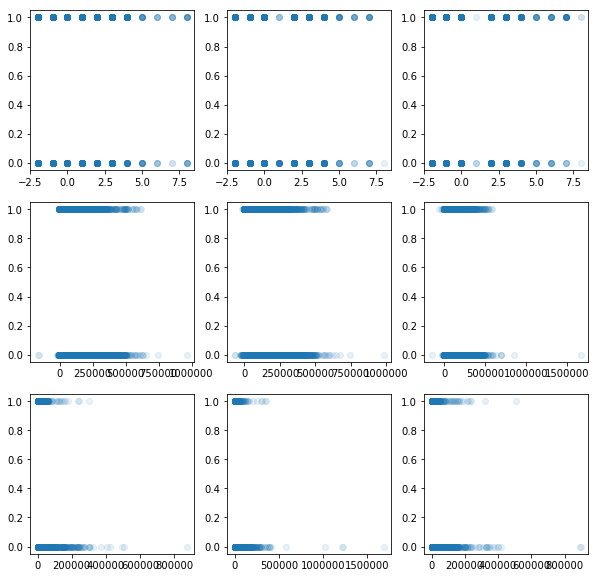

In [10]:
fig = plt.figure(figsize=(10,10))
for c in range(x_data.shape[1]):
    ax = fig.add_subplot(3, 3, c+1)
    #plt.tight_layout()
    #plt.plot(x_data[:, c], y_data, 'o', alpha=0.1)
    ax.plot(x_data[:, c], y_data, 'o', alpha=0.1)
    #plt.subplots_adjust(hspace = .001)
    #ax.xlabel(x_names[c])
    #ax.ylabel('Default')

Nothings seems to be jumping out in terms of single variables.  Considering combinations of variables might seem to make sense, but there are countless ways to combine variables.  What might be a simple approach to consider at least as a first attempt?  How about a linear combination?  Good idea!

Let's start by looking at whether the mean of each predictor for each of the classes is significantly different or not.  For example, is $X_{mean, Y=0}$ significantly different from $X_{mean, Y=1}$?

In [ ]:

pred_means = cc_data.iloc[:, :-1].as_matrix().mean(axis=0)
pred_means.shape
#pred_stats = pred_stats.as_matrix()
#targets = cc_data.iloc[:, -1].as_matrix()
#pred_stats

In [ ]:
pred_means_0 = cc_data.loc[]

Instead of directly modeling which class a sample belongs to, logistic regression starts by modeling the probability $p(Y=1\:|\:\Xv)$.  In other words, we are modelling the probability that an n-dimensional sample $\Xv$ will be in the class $Y = 1$.